<div>
<h1>Chromagram</h1> 
</div>


Let's recap the concept of Short Time Fourier Transform

### Formal Definition of the Discrete STFT

We now consider the discrete case of the STFT and specify the most important mathematical formulas as needed in practical applications. 

Let $x:[0:L-1]:=\{0,1,\ldots,L-1\}\to{\mathbb R}$ be a real-valued discrete-time (DT) signal of length $L$ obtained by equidistant sampling with respect to a fixed sampling rate $F_\mathrm{s}$ given in Hertz. 

Furthermore, let $w:[0:N-1]\to\mathbb{R}$ be a sampled  window function of length $N\in\mathbb{N}$. For example, in the case of a rectangular window one has $w(n)=1$ for $n\in[0:N-1]$. The length parameter $N$ determines the duration of the considered sections, which amounts to $N/F_\mathrm{s}$ seconds. One also introduces an additional parameter $H\in\mathbb{N}$, which is referred to as the **hop size**.  The hop size parameter is specified in samples and determines the step size in which the window is to be shifted across the signal. 

With regard to these parameters, the **discrete STFT** $\mathcal{X}$ of the signal $x$ is given by  

\begin{eqnarray}
   \mathcal{X}(m,k):= \sum_{n=0}^{N-1} x(n+mH)w(n)e^{-2\pi ikn/N}
\end{eqnarray} 

with $m\in[0:M]$ and $k\in[0:K]$. The number $M:=\lfloor \frac{L-N}{H} \rfloor$ is the maximal frame index such that the window's time range is fully contained in the signal's time range. Furthermore, $K=N/2$ (assuming that $N$ is even) is the frequency index corresponding to the Nyquist frequency. The complex number $\mathcal{X}(m,k)$ denotes the $k^\text{th}$ Fourier coefficient for the $m^\text{th}$ time frame.  Note that for each fixed time frame $m$, one obtains a **spectral vector** of size $K+1$ given by the coefficients $\mathcal{X}(m,k)$ for $k\in[0:K]$. The computation of each spectral vector amounts to a DFT of size $N$, which can be done efficiently using the FFT.



In [1]:
def stft_basic(x, w, H=8):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Args:
        x: Signal to be transformed
        w: Window function
        H: Hopsize

    Returns:
        X: The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int)
    X = np.zeros((N, M + 1), dtype='complex')
    for m in range(M + 1):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win
    K = (N + 1) // 2
    X = X[:K, :]
    return X

## STFT and Pitch Frequencies

Assuming that we are dealing with music whose pitches can be meaningfully categorized according to the equal-tempered scale, we show how an audio recording can be transformed into a feature representation that reveals the distribution of the signal's energy **across the different pitches**. Such features can be obtained from a spectrogram by converting the linear frequency axis (measured in Hertz) into a logarithmic axis (measured in pitches). The resulting representation is also called **log-frequency spectrogram**.

We start from the just defined discrete STFT. 

Let $x$ be a real-valued discrete signal with sampling rate $F_\mathrm{s}$ (Hertz) and let $\mathcal{X}$ be the discrete STFT with respect to a window $w$ of length $N\in\mathbb{N}$ and hop size $H\in\mathbb{N}$. 

We can assume that the Fourier coefficients $\mathcal{X}(n,k)$ are indexed by frame parameters $n\in\mathbb{Z}$ and frequency parameters $k\in[0:K]$, where $K=N/2$ is the frequency index corresponding to the Nyquist frequency (zero padding is needed for this assumption). 

Each Fourier coefficient $\mathcal{X}(n,k)$ is associated with the physical time position 

\begin{equation}
T_\mathrm{coef}(n) = \frac{n \cdot H}{F_\mathrm{s}}
\end{equation}

given in seconds and with the physical frequency 

\begin{equation}
F_\mathrm{coef}(k) = \frac{k \cdot F_\mathrm{s}}{N}.
\end{equation}

The main idea of the log-frequency spectrogram is to **redefine the frequency axis** to correspond to the logarithmically spaced frequency distribution of the equal-tempered scale. Identifying pitches with MIDI note numbers (where the note A4 corresponds to MIDI note number $p=69$), the **center frequencies** are given by:

\begin{equation}
F_\mathrm{MIDI}(p) = 2^{(p-69)/12} \cdot 440.
\end{equation}

As an illustration, we consider a chromatic scale played on a piano starting with the note $A0$ ($p=21$) and ending  with $C8$ ($p=108$). The resulting spectrogram reveals the exponential dependency of the fundamental frequency on the pitches of the played notes. Also, the harmonics and the notes' onset positions (vertical structures) are clearly visible. 

<img src="data/img/chromatic_scale.png" width="500px" align="left" alt="C3">
<br clear="all" />

<audio src="data/audio/chromatic_scale.wav" type="audio/mpeg" controls="controls"></audio>

In [2]:
import os
import librosa
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy

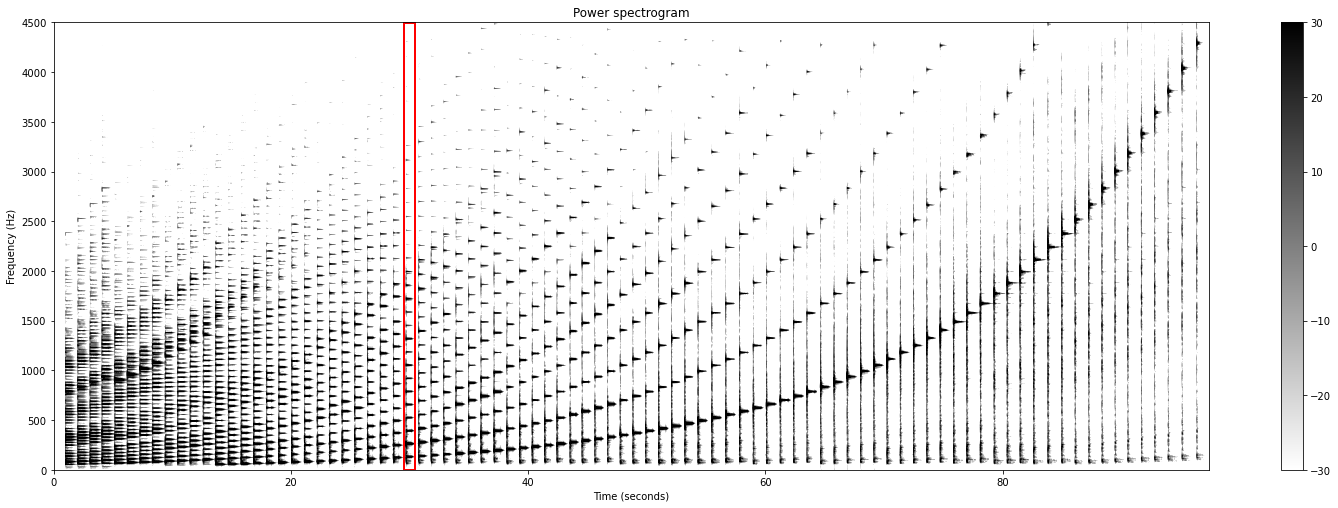

In [3]:
# Load wav
fn_wav = os.path.join('data', 'audio', 'chromatic_scale.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)

# Computation of STFT
N = 4096
H = 1024

X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')

eps = np.finfo(float).eps
Y = 20 * np.log10(eps + np.abs(X) ** 2)

time_axis = np.arange(X.shape[1]) * H / Fs
frequency_axis = np.arange(X.shape[0]) * Fs / N

###----------Plot----------###
fig = plt.figure(figsize=(21, 7))
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', extent=[time_axis[0], time_axis[-1],
                                                                    frequency_axis[0], frequency_axis[-1]])
plt.clim([-30, 30])
plt.ylim([0, 4500])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()
plt.title('Power spectrogram')

# Plot rectangle corresponding to pitch C3 (p=48)
rect = matplotlib.patches.Rectangle((29.5, 0.5), 1, 4490, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
#plt.text(28.5, -300, r'$\mathrm{C3}$', color='r', fontsize='x-large');

## Logarithmic Frequency Pooling 

The logarithmic perception of frequency motivates the use of a time&ndash;frequency representation with a logarithmic frequency axis labeled by the pitches of the equal-tempered scale. 

To derive such a representation from a given spectrogram representation, the basic idea is to assign each spectral coefficient $\mathcal{X}(n,k)$ to the pitch with a center frequency that is closest to the frequency $F_\mathrm{coef}(k)$. More precisely, we define for each pitch $p\in[0:127]$ the set

\begin{equation}
    P(p) := \{k:F_\mathrm{MIDI}(p-0.5) \leq   F_\mathrm{coef}(k) <  F_\mathrm{MIDI}(p+0.5)\}.
\end{equation}

The frequency range covered by the set $P(p)$ depends on the frequency in a **logarithmic** fashion. 

We define the **bandwidth** $\mathrm{BW}(p)$ of pitch $p$ by 

\begin{equation}
      \mathrm{BW}(p):=F_\mathrm{MIDI}(p+0.5)-F_\mathrm{MIDI}(p-0.5).
\end{equation}

The bandwidth $\mathrm{BW}(p)$ becomes smaller for decreasing pitches. In particular, it halves when decreasing the pitch by an octave. For example, for MIDI pitch $p=66$ one has a bandwidth of roughly $21.4~\mathrm{Hz}$, whereas for $p=54$ the bandwidth falls below $10.7~\mathrm{Hz}$. The following table shows various notes and their MIDI note number $p$, center frequency $F_\mathrm{MIDI}(p)$, cutoff frequencies $F_\mathrm{MIDI}(p-0.5)$ and $F_\mathrm{MIDI}(p+0.5)$, and bandwidth $\mathrm{BW}(p)$.


<img src="data/img/midi_to_hz.png" width="700px" align="middle" alt="C0">


## Log-Frequency Spectrogram

Based on the sets $P(p)$, we obtain a log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times [0:127]$ using a simple pooling procedure:

\begin{equation}
      \mathcal{Y}_\mathrm{LF}(n,p) := \sum_{k \in P(p)}{|\mathcal{X}(n,k)|^2}.
\end{equation}

By this procedure, the frequency axis is partitioned logarithmically and labeled linearly according to MIDI pitches. The following code example shows the resulting log-frequency spectrogram, where the played notes of the chromatic scale now appear in a linearly increasing fashion.

Just a reminder

\begin{equation}
F_\mathrm{coef}(k) = \frac{k \cdot F_\mathrm{s}}{N}.
\end{equation}


\begin{equation}
F_\mathrm{MIDI}(p) = 2^{(p-69)/12} \cdot 440.
\end{equation}


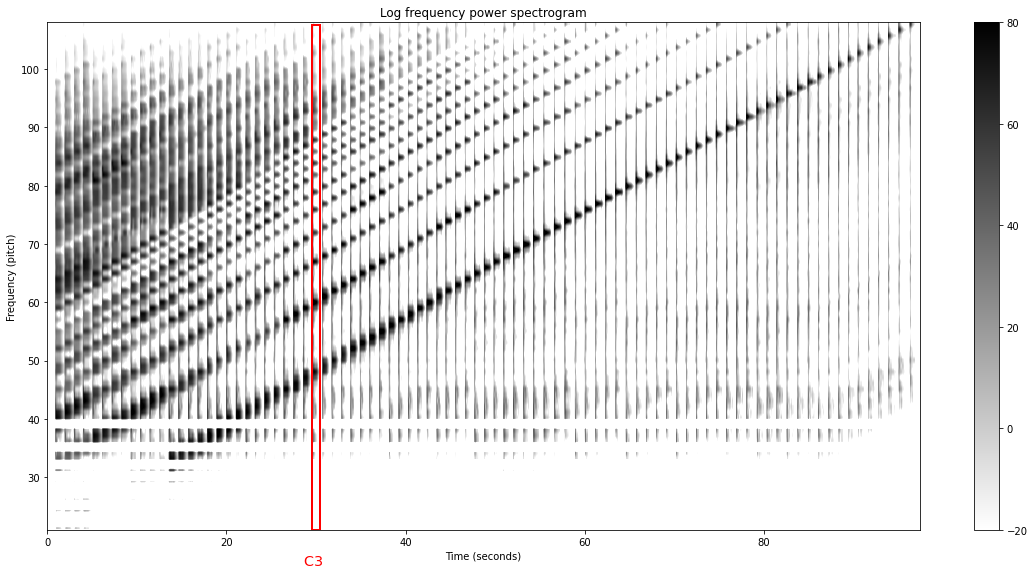

In [4]:
def F_coef(k, Fs, N):
    """Computes the center frequency/ies of a Fourier coefficient

    Args:
        k: Fourier coefficient index
        Fs: Sampling rate
        N: Window size of Fourier fransform

    Returns:
        im: Frequency value(s)
    """
    return k * Fs / N


def F_pitch(p, pitch_ref=69, freq_ref=440):
    """Computes the center frequency/ies of a MIDI pitch

    Args:
        p: MIDI pitch value(s)
        pitch_ref: Reference pitch (default: 69)
        freq_ref: Frequency of reference pitch (default: 440.0)

    Returns:
        im: Frequency value(s)
    """
    return 2 ** ((p - pitch_ref) / 12) * freq_ref


def P(p, Fs, N, pitch_ref=69, freq_ref=440):
    """Computes the set of frequency indices that are assigned to a given pitch
    
    Args:
        p: MIDI pitch value
        Fs: Sampling rate
        N: Window size of Fourier fransform
        pitch_ref: Reference pitch (default: 69)
        freq_ref:  Frequency of reference pitch (default: 440.0)

    Returns:
        im: Set of frequency indices
    """
    lower = F_pitch(p - 0.5, pitch_ref, freq_ref)
    upper = F_pitch(p + 0.5, pitch_ref, freq_ref)
    k = np.arange(N // 2 + 1)
    k_freq = F_coef(k, Fs, N)
    mask = np.logical_and(lower <= k_freq, k_freq < upper)
    return k[mask]


def compute_Y_LF(Y, Fs, N):
    """Computes a log-frequency spectrogram

    Args:
        Y: Magnitude or power spectrogram
        Fs: Sampling rate
        N: Window size of Fourier fransform
        pitch_ref: Reference pitch (default: 69)
        freq_ref: Frequency of reference pitch (default: 440.0)

    Returns:
        Y_LF: Log-frequency spectrogram
        F_coef_pitch: Pitch values
    """
    Y_LF = np.zeros((128, Y.shape[1]))
    for p in range(128):
        k = P(p, Fs, N)
        Y_LF[p, :] = Y[k, :].sum(axis=0)
    F_coef_pitch = np.arange(128)    
    return Y_LF, F_coef_pitch


Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = compute_Y_LF(Y, Fs, N)        

time_axis = np.arange(X.shape[1]) * H / Fs

fig = plt.figure(figsize=(16, 8))
eps = np.finfo(float).eps
plt.imshow(20 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', extent=[time_axis[0],
                                                                                            time_axis[-1], 0, 127])
plt.clim([-20, 80])
plt.ylim([21, 108])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (pitch)')
plt.title('Log frequency power spectrogram')
plt.colorbar()
plt.tight_layout()

# Create a Rectangle patch
rect = matplotlib.patches.Rectangle((29.5, 21), 1, 86.5, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.text(28.5, 15, r'$\mathrm{C3}$', color='r', fontsize='x-large');

Looking at the spectrogram visualization, one can make some interesting observations:

* As a general trend, the sounds for higher notes possess a cleaner harmonic spectrum than the ones for lower notes. For lower notes, the signal's energy is often contained in the higher harmonics, while the listener may still have the perception of a low-pitched sound. 

* The vertical stripes (along the frequency axis) shown by the spectrogram indicate that some of the signal's energy is spread over large parts of the spectrum. The main reason for the energy spread is due to the inharmonicities of the piano sound caused by the keystroke (mechanical noise) as well as transient and resonance effects. 

* Furthermore, the frequency content of a sound depends on the microphone's frequency response. For example, the microphone may capture only frequencies above a certain threshold as in the case of our audio example. This also may explain why there is virtually no energy visible in the fundamental frequencies for the notes $A0$ ($p=21$) to $B0$ ($p=32$).

Besides acoustic properties, there is another reason for the rather poor representation of low pitches when using the pooling strategy based on a discrete STFT. While the discrete STFT introduces a **linear** sampling of the frequency axis, the bandwidth used in the pooling strategy depends on the frequency in a **logarithmic** fashion. As a result, the set $P(p)$ may contain only very few spectral coefficients or may even be empty for small values of $p$ (which is the reason for the horizontal white stripes in the figure above). This is also demonstrated by the following code example.

In [5]:
print('Sampling rate: Fs = ', Fs)
print('Window size: N = ', N)
print('STFT frequency resolution (in Hz): Fs/N = %4.2f' % (Fs / N))

for p in [76, 64, 52, 40, 39, 38]:
    print('Set P(%d) = %s' % (p, P(p, Fs, N)))

Sampling rate: Fs =  22050
Window size: N =  4096
STFT frequency resolution (in Hz): Fs/N = 5.38
Set P(76) = [119 120 121 122 123 124 125 126]
Set P(64) = [60 61 62 63]
Set P(52) = [30 31]
Set P(40) = [15]
Set P(39) = []
Set P(38) = [14]


To resolve the issues of having an insufficient frequency resolution (in particular for low pitches), one may use a larger STFT window (at the cost of loosing time resolution). An alternative may be the usage of **interpolation techniques** or frequency refinement techniques based on **instantaneous frequency estimation**.

## Chromagram

We now discuss a strategy to increase the robustness of the log-frequency spectrogram to variations in timbre and instrumentation. The main idea is to suitably combine pitch bands corresponding to pitches that differ by one or several octaves. The human perception of pitch is periodic in the sense that two pitches are perceived as similar in "color" (playing a similar harmonic role) if they differ by an **octave**. 

Based on this observation, a pitch can be separated into two components, which are referred to as **tone height** and **chroma**. The tone height refers to the octave number and the chroma to the respective pitch spelling attribute contained in the set 

$$
\{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\mathrm{D}^\sharp,\ldots,\mathrm{B}\}.
$$

Enumerating the chroma values, we identify this set with $[0:11]$ where $0$ refers to chroma $\mathrm{C}$, $1$ to $\mathrm{C}^\sharp$, and so on. A **pitch class** is defined as the set of all pitches that share the same chroma. For example, the pitch class corresponding to the chroma  $\mathrm{C}$ is the set  $\{\ldots,\,\mathrm{C0},\mathrm{C1},\mathrm{C2},\mathrm{C3},\ldots\}$ consisting of all pitches separated by an integer number of octaves. For simplicity, we use the terms chroma and pitch class interchangeably.

The main idea of **chroma features** is to aggregate all spectral information that relates to a given pitch class into a single coefficient. Given a pitch-based log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times[0:127]\to \mathbb{R}_{\geq 0}$, a **chroma representation** or **chromagram** $\mathbb{Z}\times[0:11]\to \mathbb{R}_{\geq 0}$ can be derived by summing up all pitch coefficients that belong to the same chroma:

\begin{equation}
      \mathcal{C}(n,c) := \sum_{\{p \in [0:127]\,:\,p\,\mathrm{mod}\,12 = c\}}{\mathcal{Y}_\mathrm{LF}(n,p)}
\end{equation}

for $c\in[0:11]$. Continuing our example, the following code example generates a chromagram of the chromatic scale, where the cyclic nature of chroma features becomes evident. 

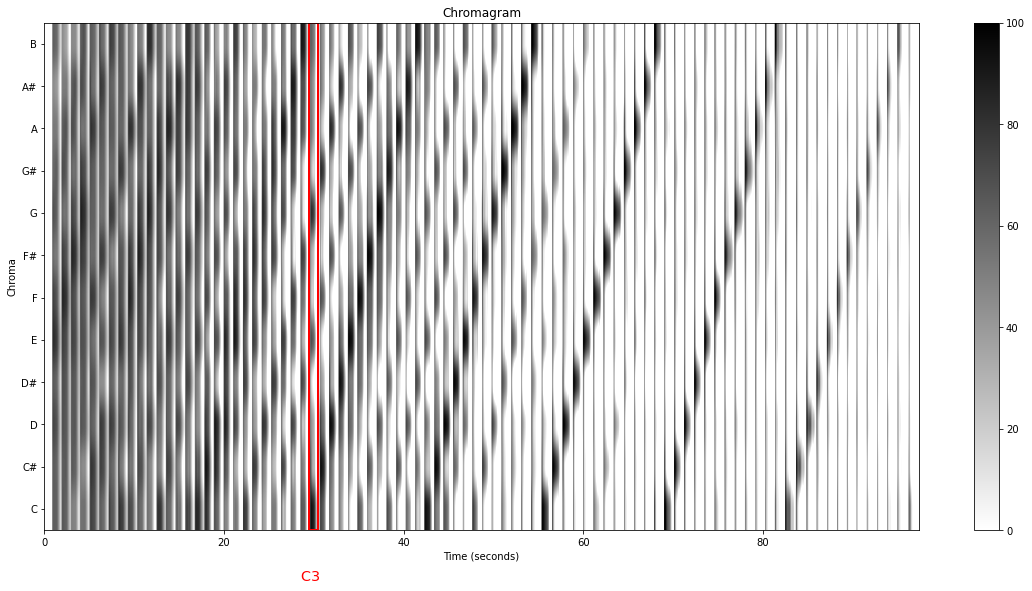

In [6]:
def compute_chromagram(Y_LF):
    """Computes a chromagram

    Args:
        Y_LF: Log-frequency spectrogram

    Returns:
        C: Chromagram
    """
    C = np.zeros((12, Y_LF.shape[1]))
    p = np.arange(128)
    for c in range(12):
        mask = (p % 12) == c
        C[c, :] = Y_LF[mask, :].sum(axis=0)
    return C

C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(16, 8))

time_axis = np.arange(X.shape[1]) * H / Fs

chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.imshow(20 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', extent=[time_axis[0], 
                                                                                         time_axis[-1], 0, 12])
plt.clim([0, 100])
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
plt.title('Chromagram')
plt.colorbar()
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()

rect = matplotlib.patches.Rectangle((29.5, 0.0), 1, 12, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.text(28.5, -1.2, r'$\mathrm{C3}$', color='r', fontsize='x-large');


Because of the octave equivalence, the increasing notes of the chromatic scale are "wrapped around" the chroma axis. As with the log-frequency spectrogram, the resulting chromagram of the considered audio example is rather noisy, in particular for the lower notes. 

Furthermore, because of the presence of higher harmonics, the energy is typically spread across various chroma bands even when playing a single note at a time. For example, playing the note $\mathrm{C3}$, the third harmonic corresponds to $\mathrm{G4}$ and the fifth harmonic to $\mathrm{E5}$.  Therefore, when playing the note $\mathrm{C3}$ on the piano, not only the chroma band $\mathrm{C}$, but also the chroma bands $\mathrm{G}$ and $\mathrm{E}$ contain a substantial portion of the signal's energy.

## Example: Burgmüller


As an illustrating example, we now consider the first four measures of Op. 100, No. 2 by Friedrich Burgmüller. In the lower staff of the score (left hand), one can see that the chord consisting of the three notes $\mathrm{A3}$ ($p=57$), $\mathrm{C4}$ ($p=60$), and $\mathrm{E4}$ ($p=64$) is played every quarter beat&mdash;altogether eight times over the first four measures. These chords are also clearly visible in the the log-frequency spectrogram and chromagram shown below. Furthermore, the patterns resulting from the two sixteenth-note phrases (upper staff of the score, right hand) are clearly revealed. Looking at the visualizations, it is important to note that **inharmonicities** and **partials** may result in substantial contributions in certain frequency and chroma bands not relating to the fundamental frequencies of the notes shown in the score. Another important issue is the imperfection of the Fourier analysis, also known as **spectral leakage**, which is the result of the frequency smearing introduced by the window function. 

<img src="data/img/burgmuller.png" width="500px" align="left" alt="C1">

<br clear="all" />

<audio src="data/audio/burgmuller.wav" type="audio/mpeg" controls="controls"></audio>

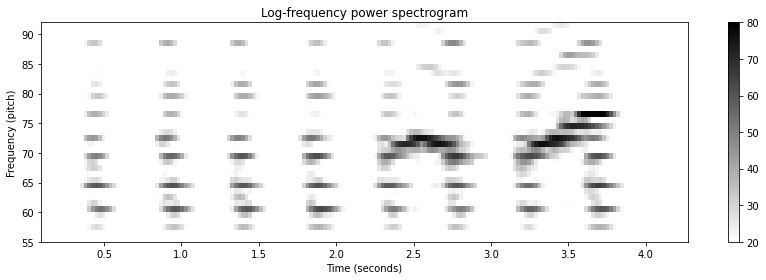

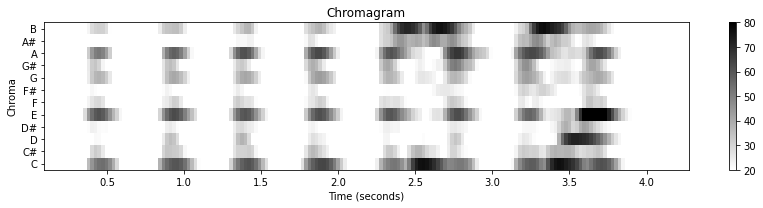

In [7]:
fn_wav = os.path.join('data', 'audio', 'burgmuller.wav')
x, Fs = librosa.load(fn_wav)
# ipd.display(ipd.Audio(x, rate=Fs))

N = 4096
H = 512
w = scipy.signal.get_window('hann', N)
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window=w, pad_mode='constant')
t = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H, n_fft=N)
freq = librosa.fft_frequencies(sr=Fs, n_fft=N)

Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = compute_Y_LF(Y, Fs, N)
C = compute_chromagram(Y_LF)

###----------Plot----------###

fig = plt.figure(figsize=(12, 4))
plt.imshow(20 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', extent=[t[0], t[-1], 0, 128])
plt.clim([20, 80])
plt.ylim([55, 92])
plt.title('Log-frequency power spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (pitch)')
plt.colorbar()
plt.tight_layout()

fig = plt.figure(figsize=(12, 3))
plt.imshow(20 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', extent=[t[0], t[-1], 0, 12])
plt.clim([20, 80])
plt.title('Chromagram')
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
plt.colorbar()
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()